[View in Colaboratory](https://colab.research.google.com/github/gauravsingh1012/Understanding-Pandas-For-Data-Analysis-and-Data-Visualisation/blob/master/%E2%80%8BPandas_For_Finance_Chapter_3__Time_series_Stock__Data.ipynb)

#Chapter 3: Time-series Stock Data

** Notebook Setup: Loading historical stock data from the quandl **

In [1]:
!pip install quandl

    100% |████████████████████████████████| 51kB 2.7MB/s 
  Running setup.py bdist_wheel for inflection ... - \ done
  Stored in directory: /content/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


In [2]:
!pip install kaggle

    100% |████████████████████████████████| 51kB 3.0MB/s 
    100% |████████████████████████████████| 51kB 3.8MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/56/65/d9/88f616157b8a1848ce77c35a398b09d0566ba1fd9cc34eaa03
Successfully built kaggle


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!kaggle datasets download jes2ica/sp-500 -f sp500.csv -p ./

  0% 0.00/365k [00:00<?, ?B/s]
100% 365k/365k [00:00<00:00, 44.3MB/s]


In [5]:
ls -latr sp500.csv

-rw-r--r-- 1 root root 373986 Aug 21 17:00 sp500.csv


In [0]:
import quandl
import pandas as pd
import numpy as np
import datetime

In [0]:
quandl.ApiConfig.api_key = input('Please enter your quandl Key: ')
exchange = 'WIKI'

In [0]:
def get(tickers, start, end):
   def data(ticker):
       return quandl.get('%s/%s' % (exchange, ticker),start_date = start,end_date = end)
   datas = map(data, tickers)
   return pd.concat(datas, keys=tickers, names=['Ticker','Date'])

In [10]:
start = datetime.date(2014, 1, 1)
end = datetime.date(2017, 12, 31)

tickers = ['AAPL','MSFT','GE','IBM','AA','DAL','UAL', 'PEP', 'KO']
all_data = get(tickers, start, end)
all_data[:5]

Open    High      Low     Close      Volume  Ex-Dividend  \
Ticker Date                                                                     
AAPL   2014-01-02  555.68  557.03  552.021  553.1300   8381600.0          0.0   
       2014-01-03  552.86  553.70  540.430  540.9800  14016700.0          0.0   
       2014-01-06  537.45  546.80  533.600  543.9300  14736100.0          0.0   
       2014-01-07  544.32  545.96  537.925  540.0375  11328900.0          0.0   
       2014-01-08  538.81  545.56  538.690  543.4600   9233200.0          0.0   

                   Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Ticker Date                                                                   
AAPL   2014-01-02          1.0  73.862376  74.041821  73.376012   73.523423   
       2014-01-03          1.0  73.487534  73.599189  71.835308   71.908415   
       2014-01-06          1.0  71.439198  72.682024  70.927447   72.300536   
       2014-01-07          1.0  72.352376  72.570369  71.502337   71.783135   
       2014-01-08          1.0  71.619973  72.517200  71.604022   72.238063   

                   Adj. Volume  
Ticker Date                     
AAPL   2014-01-02   58671200.0  
       2014-01-03   98116900.0  
       2014-01-06  103152700.0  
       2014-01-07   79302300.0  
       2014-01-08   64632400.0

In [0]:
sp_500 = pd.read_csv("./sp500.csv")

sp_500.set_index(pd.DatetimeIndex(sp_500['Date']), inplace = True)

sp_500 = sp_500.loc[start:end]


>**1. Visualizing financial time-series data**

>>**i.   Plotting closing prices**:  The closing price of a stock can be easily plotted with matplotlib for either a single
stock or multiple stocks on the same graph. We have already pulled down all the
historical data for our stocks, so to visualize the closing prices, we will need to
extract those values and pass and plot them with .plot() .

>>Most of the examples will focus on the adjusted closing price instead of the close
price as this takes into account splits and dividends and reflects a continuous change
in the value of each stock. To facilitate the use of this field, we can extract just the
adjusted close value for each stock into its own pandas object.

>>This happens to be very simple because of the way we organized it when it was
retrieved. We first extract the Adj Close column and then reset the index to move
the dates into a column:


In [12]:
# reset the index to make everything columns
just_closing_prices = all_data[['Adj. Close']].reset_index()
just_closing_prices[:5]

,Ticker,Date,Adj. Close
0,AAPL,2014-01-02,73.523423
1,AAPL,2014-01-03,71.908415
2,AAPL,2014-01-06,72.300536
3,AAPL,2014-01-07,71.783135
4,AAPL,2014-01-08,72.238063


>>We moved the dates into a column because we now want to pivot Date into the
index and each Ticker value into a column

In [13]:
daily_close_px = just_closing_prices.pivot('Date', 'Ticker','Adj. Close')
daily_close_px[:5]

Ticker,AA,AAPL,DAL,GE,IBM,KO,MSFT,PEP,UAL
Date,,,,,,,,,
2014-01-02,NaN,73.523423,26.382325,24.266002,162.670896,36.092891,33.532800,73.805440,37.73
2014-01-03,NaN,71.908415,27.839544,24.248354,163.644133,35.915356,33.307202,73.931296,39.95
2014-01-06,NaN,72.300536,27.896690,24.054226,163.082988,35.746698,32.603338,73.967255,39.36
2014-01-07,NaN,71.783135,27.410950,24.080698,166.335879,35.853219,32.856007,75.046019,38.69
2014-01-08,NaN,72.238063,28.382429,24.010106,164.810264,35.453765,32.269454,74.830266,41.02


>>Using this DataFrame , we can easily plot a single stock's closing price by selecting
the specific column and calling .plot() . The following command plots AAPL:

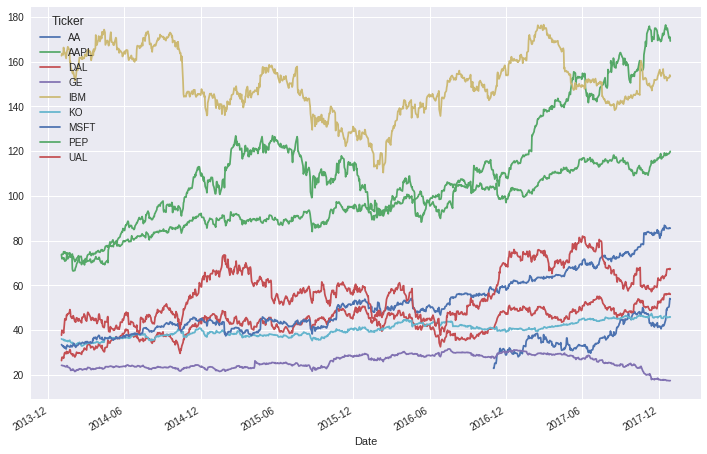

In [14]:
_ = daily_close_px.plot(figsize=(12,8));

>>**ii.   Plotting volume-series data**: Stock trading volume data is normally plotted using matplotlib bar charts. This
is made almost embarrassingly easy using pandas and the .bar() function. The
following command plots the volume for MSFT :

In [0]:
msftV = all_data.Volume.loc['MSFT']  

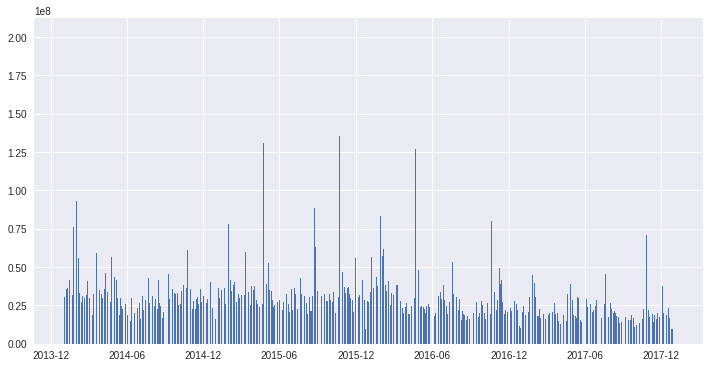

In [16]:
import matplotlib.pyplot as plt 
plt.bar(msftV.index, msftV)
plt.gcf().set_size_inches(12,6)

>>**iii.   Combined price and volumes**: A common type of financial graph plots a stock trading volume relative to its closing
price. The following command constructs this combined chart:

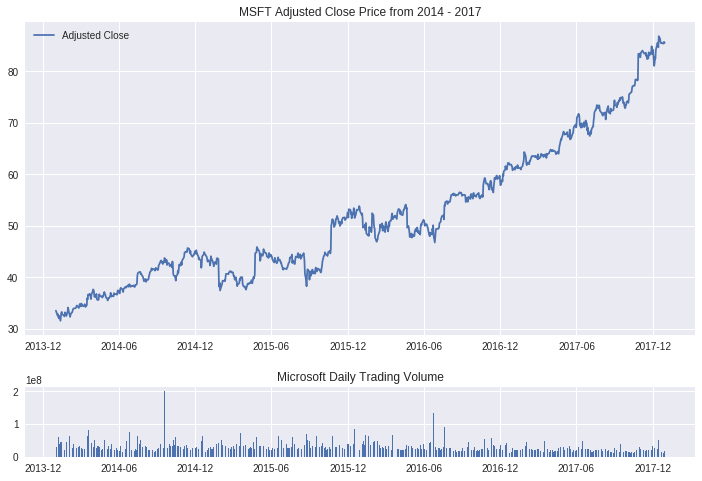

In [17]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(daily_close_px.index,
daily_close_px['MSFT'],
label='Adjusted Close')
plt.title('MSFT Adjusted Close Price from 2014 - 2017')
plt.legend(loc=2)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(msftV.index, msftV)
plt.title('Microsoft Daily Trading Volume')
plt.gcf().set_size_inches(12,8)
plt.subplots_adjust(hspace=0.75)

>>**iv.    Plotting candlesticks**:   The open-high-low-close plots, often referred to as candlestick charts, are a type
of chart used to illustrate movements in the price of a financial instrument over
time. These charts generally consist of a thin vertical line for each unit of time that
represents the range of the price during that unit of time and then overlying the thin
line is a thicker bar that represents the spacing between the open and close prices.
From these charts, it is easy to get a visual feel for the overall movement of the price
not only over the entire duration of the chart but also how much the price varies
during each unit of measurement.


>>To demonstrate the process of creating candlestick charts, we will utilize the data
for MSFT from the month of December 2014, plotting each day's data as a separate
candlestick.

>>We will also demonstrate the process of selecting specific dates for the x axis labels as
displaying labels for all 31 days of the month will be too cluttered. The out chart will
display labels only for the Mondays during the month.

>>Additionally, we will format the labels in the MMM DD format, where MMM represents
a three-character month code (in this case, always Dec), and DD will be a two-digit
date. As an example, the label for Monday December 15 will be Dec 15.
The first step we will perform is to select the subset of data for MSFT in Dec 15 from
our DataFrame of adjusted close values. We have pivoted both Ticker and Date
into the index, so we will use chained calls to .loc to first retrieve only the rows
for MSFT and then a slice using a partial date specification to extract only rows for
2014-12 :

In [18]:
subset = all_data.loc['MSFT'].loc['2014-12':'2014-12'].reset_index()
subset[:5]

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2014-12-01,47.88,48.78,47.710,48.62,31191575.0,0.0,1.0,44.382499,45.216757,44.224917,45.068444,31191575.0
1,2014-12-02,48.84,49.05,48.200,48.46,25773478.0,0.0,1.0,45.272374,45.467034,44.679124,44.920132,25773478.0
2,2014-12-03,48.44,48.50,47.805,48.08,23534752.0,0.0,1.0,44.901593,44.957210,44.312978,44.567890,23534752.0
3,2014-12-04,48.39,49.06,48.200,48.84,30345132.0,0.0,1.0,44.855245,45.476304,44.679124,45.272374,30345132.0
4,2014-12-05,48.82,48.97,48.380,48.42,27313449.0,0.0,1.0,45.253835,45.392878,44.845976,44.883054,27313449.0


>>We reset the index to move Date into a column as, in the end, the date for the
charting function needs to be in a column. The process is complicated in that the
date-formatting functions we will use do not use the same representation for a date
that pandas uses. We will, therefore, need to convert the values in our Date column
into that representation and add them as a new column to our set of data.

>>The representation of a date required by the date formatter is a floating point number
representing the number of days since the 0001-01-01 universal time plus 1 .

>>We can convert dates to this representation by first converting our pandas date to
pydatetime and then using the matplotlib.date2num function to convert once
more into the representation needed for the matplotlib label formatter. The following
command will use the .apply() method of the DataFrame to convert each value in
the Date column to this representation and add it as the new column date_num :

In [19]:
import matplotlib.dates as mdates
subset['date_num'] = subset['Date'].apply(lambda date: mdates.date2num(date.to_pydatetime()))
subset[:5]

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,date_num
0,2014-12-01,47.88,48.78,47.710,48.62,31191575.0,0.0,1.0,44.382499,45.216757,44.224917,45.068444,31191575.0,735568.0
1,2014-12-02,48.84,49.05,48.200,48.46,25773478.0,0.0,1.0,45.272374,45.467034,44.679124,44.920132,25773478.0,735569.0
2,2014-12-03,48.44,48.50,47.805,48.08,23534752.0,0.0,1.0,44.901593,44.957210,44.312978,44.567890,23534752.0,735570.0
3,2014-12-04,48.39,49.06,48.200,48.84,30345132.0,0.0,1.0,44.855245,45.476304,44.679124,45.272374,30345132.0,735571.0
4,2014-12-05,48.82,48.97,48.380,48.42,27313449.0,0.0,1.0,45.253835,45.392878,44.845976,44.883054,27313449.0,735572.0


>>Our data is almost ready for use in drawing our candlestick chart. But unfortunately,
the candlestick_ohlc function does not know how to work with DataFrame
objects, so we must convert our data to another format. Specifically, we need to
provide this function with a list of tuples, where each tuple consists of the date_num ,
Open , High , Low , and Close ). We can organize the required data this way with the
following command:

In [20]:
subset_as_tuples = [tuple(x) for x in subset[['date_num',
'Open',
'High',
'Low',
'Close']].values]
subset_as_tuples

[(735568.0, 47.88, 48.78, 47.71, 48.62),
 (735569.0, 48.84, 49.05, 48.2, 48.46),
 (735570.0, 48.44, 48.5, 47.805, 48.08),
 (735571.0, 48.39, 49.06, 48.2, 48.84),
 (735572.0, 48.82, 48.97, 48.38, 48.42),
 (735575.0, 48.26, 48.35, 47.445, 47.695),
 (735576.0, 47.11, 47.92, 47.05, 47.59),
 (735577.0, 47.58, 47.66, 46.7001, 46.9),
 (735578.0, 47.08, 47.74, 46.68, 47.17),
 (735579.0, 46.78, 47.73, 46.67, 46.95),
 (735582.0, 47.2, 47.67, 46.55, 46.67),
 (735583.0, 45.9, 46.34, 45.13, 45.16),
 (735584.0, 45.05, 45.945, 44.9, 45.74),
 (735585.0, 46.58, 47.52, 46.3386, 47.52),
 (735586.0, 47.63, 48.1, 47.17, 47.66),
 (735589.0, 47.78, 48.12, 47.71, 47.98),
 (735590.0, 48.37, 48.8, 48.13, 48.45),
 (735591.0, 48.64, 48.64, 48.08, 48.14),
 (735593.0, 48.41, 48.41, 47.82, 47.88),
 (735596.0, 47.7, 47.78, 47.26, 47.45),
 (735597.0, 47.44, 47.62, 46.84, 47.02),
 (735598.0, 46.73, 47.44, 46.45, 46.45)]

>>The input data for our chart is now ready. To set up the chart to know how we
would like to format the x axis labels, we need to do two things. The first thing to
do is create an instance of DateFormatter and configure it to format the dates as
we want, as shown here:

In [0]:
from matplotlib.dates import DateFormatter
week_formatter = DateFormatter('%b %d')
# e.g., Jan 12

>>We also need to let the chart know how to select which data points on the x axis that
we would like to label. We do this by creating an instance of WeekdayLocator and
initializing it with the constant MONDAY and finally we are all set to draw:

In [0]:
from matplotlib.dates import (WeekdayLocator, MONDAY)
mondays = WeekdayLocator(MONDAY) # major ticks on the mondays

([<matplotlib.lines.Line2D at 0x7f0c21e72f60>,
  <matplotlib.patches.Rectangle at 0x7f0c2185c320>])

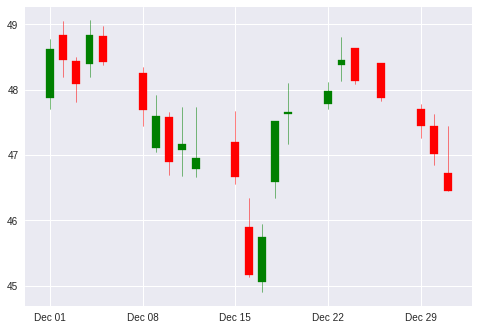

In [23]:
plt.figure(figsize=(12,8))
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_major_formatter(week_formatter)
from matplotlib.finance import candlestick_ohlc
candlestick_ohlc(ax, subset_as_tuples, width=0.6,colorup='g',colordown='r')

>**2.   Fundamental financial calculations**

>There are a number of analyses and data conversions commonly used to analyze the
performance of historical stock quotes. These calculations generally relate to either
analyzing the rate of return from an investment in a stock over a daily or monthly
basis or how multiple stocks perform relative to each other or a market index. The
calculations could also relate to determining the riskiness of an investment in a stock
relative to others. We will now look at all of these operations using our previously
collected stock data.

>>**i.    Calculating simple daily percentage change**: The simple daily percentage change (without dividends and other factors) is the
amount of percentage change in the value of a stock over a single day of trading. It is
defined by the following formula: 

>>rt = (pt0/pt1) - 1 

>>Using this formula, the following command calculates the percentage change for AAPL
between 2014-01-04 and 2014-01-05 :
                    

In [24]:
AA_p_t0 = daily_close_px.iloc[0]['AAPL'] #Pt-1
AA_p_t1 = daily_close_px.iloc[1]['AAPL'] #Pt
r_t1 = AA_p_t1 / AA_p_t0 - 1 # returns
AA_p_t0, AA_p_t1, r_t1

(73.523423281972, 71.908414888148, -0.02196590313307678)

>> So, between those two days, there was a drop of 2.2 percent.
We can use this result to determine the correctness of applying this formula to an
entire DataFrame .

>>There are several ways of calculating the simple daily return across an entire
DataFrame . One means is by using slicing. The following command uses the trick of
dividing a slice of the DataFrame that excludes the first row by the values sliced to
exclude the last value:

In [25]:
dpc_1 = daily_close_px.iloc[1:] / daily_close_px.iloc[:-1].values - 1
dpc_1.loc[:,'AAPL':'GE'][:5]

Ticker,AAPL,DAL,GE
Date,,,
2014-01-03,-0.021966,0.055235,-0.000727
2014-01-06,0.005453,0.002053,-0.008006
2014-01-07,-0.007156,-0.017412,0.001101
2014-01-08,0.006338,0.035441,-0.002931
2014-01-09,-0.012772,0.042282,0.000368


>>HOW THIS WORK: 

In [26]:
daily_close_px.iloc[1:][:5]

Ticker,AA,AAPL,DAL,GE,IBM,KO,MSFT,PEP,UAL
Date,,,,,,,,,
2014-01-03,NaN,71.908415,27.839544,24.248354,163.644133,35.915356,33.307202,73.931296,39.95
2014-01-06,NaN,72.300536,27.896690,24.054226,163.082988,35.746698,32.603338,73.967255,39.36
2014-01-07,NaN,71.783135,27.410950,24.080698,166.335879,35.853219,32.856007,75.046019,38.69
2014-01-08,NaN,72.238063,28.382429,24.010106,164.810264,35.453765,32.269454,74.830266,41.02
2014-01-09,NaN,71.315448,29.582492,24.018930,164.292958,35.267353,32.061904,74.479668,43.80


In [27]:
daily_close_px.iloc[:-1][:5]

Ticker,AA,AAPL,DAL,GE,IBM,KO,MSFT,PEP,UAL
Date,,,,,,,,,
2014-01-02,NaN,73.523423,26.382325,24.266002,162.670896,36.092891,33.532800,73.805440,37.73
2014-01-03,NaN,71.908415,27.839544,24.248354,163.644133,35.915356,33.307202,73.931296,39.95
2014-01-06,NaN,72.300536,27.896690,24.054226,163.082988,35.746698,32.603338,73.967255,39.36
2014-01-07,NaN,71.783135,27.410950,24.080698,166.335879,35.853219,32.856007,75.046019,38.69
2014-01-08,NaN,72.238063,28.382429,24.010106,164.810264,35.453765,32.269454,74.830266,41.02


>>so when we do the division (and subsequently subtract 1 from the division), pandas
matches the row/column in the DataFrame to the row/column in the array. for example: 2014-01-03/ APPL = 71.908415	/ 73.523423 -1 = -0.021966

>>Better way of doing this calculation is by performing a shift of the values using
the pandas **.shift() method**:

In [28]:
dpc_2 = daily_close_px / daily_close_px.shift(1) - 1
dpc_2.loc[:,'AAPL':'GE'][:5]  

Ticker,AAPL,DAL,GE
Date,,,
2014-01-02,NaN,NaN,NaN
2014-01-03,-0.021966,0.055235,-0.000727
2014-01-06,0.005453,0.002053,-0.008006
2014-01-07,-0.007156,-0.017412,0.001101
2014-01-08,0.006338,0.035441,-0.002931


>>**This process performs alignment as .shift() moves the values along the axis and
results in a pandas object instead of a list of values.
Probably the easiest way to do this is with the built-in .pct_change() method** of a
pandas Series or DataFrame . This calculation is actually so commonly performed in
pandas and finance that it was baked into the library:

In [29]:
daily_pct_change = daily_close_px.pct_change()
daily_pct_change.loc[:,'AA':'GE'][:5]  

Ticker,AA,AAPL,DAL,GE
Date,,,,
2014-01-02,NaN,NaN,NaN,NaN
2014-01-03,NaN,-0.021966,0.055235,-0.000727
2014-01-06,NaN,0.005453,0.002053,-0.008006
2014-01-07,NaN,-0.007156,-0.017412,0.001101
2014-01-08,NaN,0.006338,0.035441,-0.002931


>>The last thing we will want to do here is set the NaN values to 0 . This is not strictly
required, and the examples will work without it, but it is a good practice:

In [30]:
daily_pct_change.fillna(0, inplace=True)
daily_pct_change[:5]

Ticker,AA,AAPL,DAL,GE,IBM,KO,MSFT,PEP,UAL
Date,,,,,,,,,
2014-01-02,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-03,0.0,-0.021966,0.055235,-0.000727,0.005983,-0.004919,-0.006728,0.001705,0.058839
2014-01-06,0.0,0.005453,0.002053,-0.008006,-0.003429,-0.004696,-0.021132,0.000486,-0.014768
2014-01-07,0.0,-0.007156,-0.017412,0.001101,0.019946,0.002980,0.007750,0.014584,-0.017022
2014-01-08,0.0,0.006338,0.035441,-0.002931,-0.009172,-0.011141,-0.017852,-0.002875,0.060222


>>**ii.    Calculating simple daily cumulative returns**:  The cumulative daily rate of return is useful to determine the value of an investment
at regular intervals after investment. This is calculated from the daily percentage
change values by multiplying (1 + the current day's percentage change) with the
cumulative product of all of the previous values. This is represented by the following
formula:  

>>Io = 1,

>>Ii  = (1+rt) x It-1

>>This is actually calculated very succinctly using the following code and the
.cumprod() method:

In [31]:
cum_daily_return = (1 + daily_pct_change).cumprod()
cum_daily_return[:5]

Ticker,AA,AAPL,DAL,GE,IBM,KO,MSFT,PEP,UAL
Date,,,,,,,,,
2014-01-02,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2014-01-03,1.0,0.978034,1.055235,0.999273,1.005983,0.995081,0.993272,1.001705,1.058839
2014-01-06,1.0,0.983367,1.057401,0.991273,1.002533,0.990408,0.972282,1.002192,1.043202
2014-01-07,1.0,0.976330,1.038989,0.992364,1.022530,0.993360,0.979817,1.016809,1.025444
2014-01-08,1.0,0.982518,1.075812,0.989455,1.013152,0.982292,0.962325,1.013886,1.087199


>>This informs us that the value of 1 dollar invested in UAL on 2012-01-03 would be worth
$1.087 on 2014-01-08 .
We can plot the cumulative returns to see how the different stocks compare. This
gives a nice view of how the stocks will change your investment over time and how
they perform relative to each other:

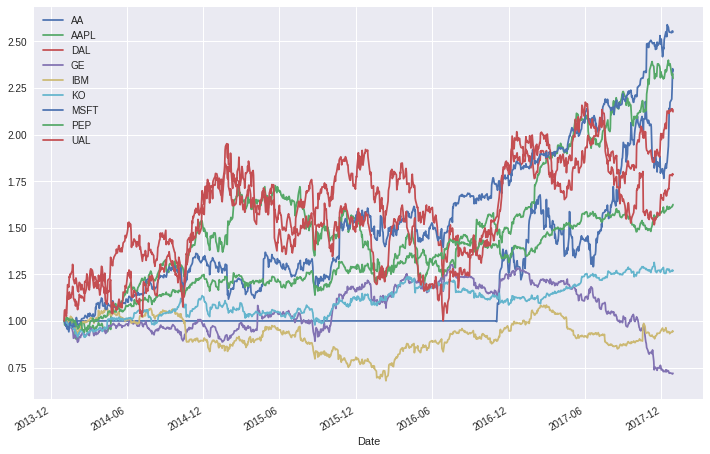

In [32]:
cum_daily_return.plot(figsize=(12,8))
plt.legend(loc=2);

>**3.  Analyzing the distribution of returns**

>If you want to get a feel for the difference in distribution of the daily returns for
a particular stock, you can plot the returns using several common visualizations

>>**i.    Histograms**: Histograms give you an overall feel for the distribution of returns. In general, return
distributions are approximately normal in shape, demonstrating a familiar bell curve
shape.

>> Histograms can be generated using the .hist() method of a pandas Series . The
method can be supplied with a number of different parameters, of which one of the
most important is the number of bins that the data is to be lumped into. We will use
50 bins, which gives a good feel for the distribution of daily changes across three
years of data.

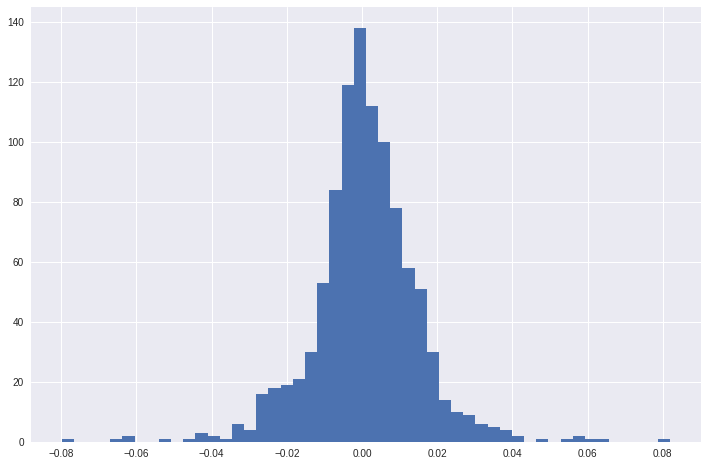

In [33]:
aapl = daily_pct_change['AAPL']
aapl.hist(bins=50, figsize=(12,8));

>>This chart tells us several things. First, **most of the daily changes center around
0.0, and there is a small amount of skew to the left, but the data appears fairly
symmetrical and normally distributed**.

>>If we use the **.describe()** method on this data, we will get some **useful summary
statistics** that describe the histogram:

In [34]:
aapl.describe()

count    1006.000000
mean        0.000930
std         0.014225
min        -0.079927
25%        -0.005662
50%         0.000647
75%         0.008251
max         0.081982
Name: AAPL, dtype: float64

>>Using this information, some of our conclusions from the histogram can be
rationalized. The mean of the distributions is very close to 0.0 , being 0.0001 . The
standard deviation is 0.014 . 

>>The percentiles tell us that 25 percent of the points fall
below -0.005 , 50 percent below 0.006 , and 75 percent below 0.008.

>>We can provide parameters to .describe() to further specify the percentiles that
we would like to calculate. The following command asks the method to give us the
breakdown at the 2.5 , 50 , and 97.5 percentiles:

In [35]:
aapl.describe(percentiles=[0.025, 0.5, 0.975])

count    1006.000000
mean        0.000930
std         0.014225
min        -0.079927
2.5%       -0.027122
50%         0.000647
97.5%       0.029444
max         0.081982
Name: AAPL, dtype: float64

>>This range of percentiles is commonly used to formulate a 95 percent confidence
interval. If our return distribution is perfectly normally distributed (with an equal
distribution of gains and losses), then we would expect our 2.5 percent value to be
-1.95996 times the standard deviation less than the mean, and the 97.5 percent value
to be 1.95996 times the standard deviation above the mean.

>>Manually calculating these, we get the 2.5 percent value as -0.027 and the 97.5
percent value as 0.029. These are roughly equivalent, again giving us a good feeling
that this stock has an equal distribution of gains and losses.

>>And, statistically speaking, this range of values gives us the 95 percent confidence
interval, which tells us that over the last three years, the daily return on 95 percent of
the days will fall within -0.027 percent and 0.027 percent.

>>To compare the return distributions of more than one stock using histograms, we can
visualize these distributions on all stocks in a single visual by creating a matrix of
histograms. As demonstrated here, pandas allows us to do this very simply:

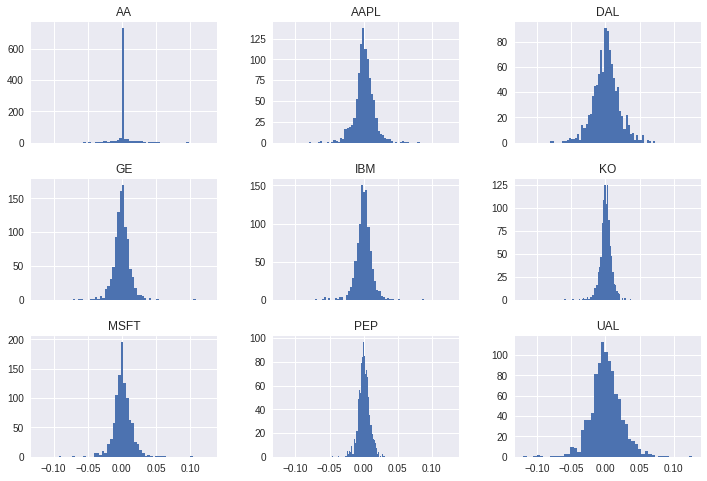

In [36]:
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8));

>>Using this chart, we get a feel for the difference in performance of these nine stocks
during this time. Stocks with a wider interval have higher fluctuation in returns and,
hence, are more volatile. Stocks where the curve is skewed demonstrate a propensity
to have either larger (skewed right) or smaller rates (skewed left) of return during
the period of measurement.

>>**ii.   Q-Q plots**:
A Q-Q plot, short for Quantile-Quantile plot, is a probability plot comparing two
probability distributions by plotting their quantiles against each other. We can use a
Q-Q plot of the returns of a stock compared to a normal distribution to get a feel of
how close our returns are to a normal distribution. We can get an idea of this from
histograms, but a Q-Q plot gives a much better representation.

>>We can create a Q-Q plot of our returns using the probplot() function of scipy.
stats .

>>As an example, we can plot the returns of AAPL against a sequence of random
normal values. We can generate this plot using the following command that
generates a Q-Q plot of our distribution date compared to a normal distribution:

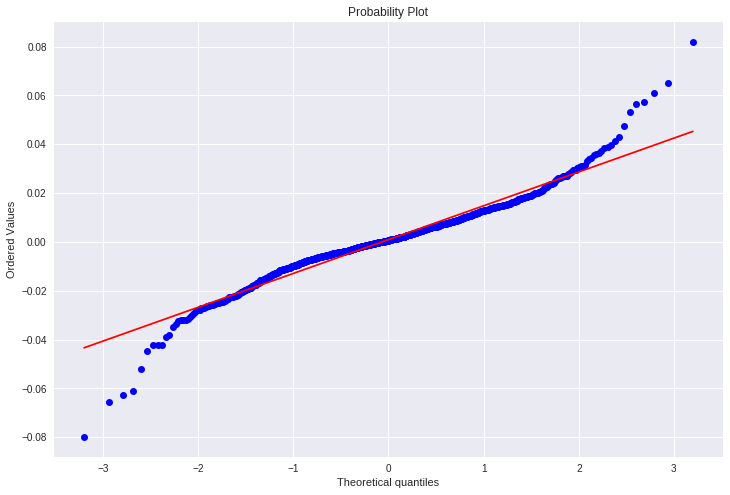

In [37]:
import scipy.stats as stats
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)
stats.probplot(aapl, dist='norm', plot=ax)
plt.show();

>>We will not get into detailed analysis of Q-Q plots in this book. For more details,
I recommend http://en.wikipedia.org/wiki/Q-Q_plot and http://stats.
stackexchange.com/questions/101274/how-to-interpret-a-qq-plot.

>>A distribution of data in a Q-Q plot would show perfect correspondence to a normal
distribution if all of the blue dots fell exactly along the red line and the slope of the
red line would be 1.0 (representing perfect correlation and an R^2 value of 1.0 ).
Our returns are correlated at a level of 0.9295, which is representative of a very high
degree of correlation.

>>Between quantiles -2 and +2, most of our data is very close to being perfectly
correlated. This range is also very close to our 95 percent confidence interval (just
slightly wider, which actually means higher confidence). It is outside this range that
we begin to see differences in the levels of correlation of the distribution with what
appears to be a similar amount of skew along both tails but perhaps with a little
more towards the positive.

>>**iii.    Box-and-whisker plots**:    A box plot is a convenient way to graphically depict groups of data through their
quartiles. The box portion of the plot represents the range from the low quantile to
the high quantile, and the box is split by a line that represents the median value.
A box plot may also have lines extending out from both sides of the box, which
represent the amount of variability outside of the upper and lower quartiles. These
are often referred to as whiskers, hence the use of the term box-and-whisker plot.
To demonstrate this, the following command creates a box-and-whisker plot for the
 daily returns:

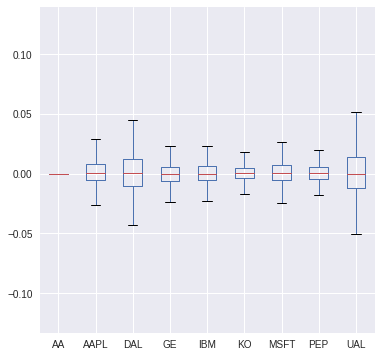

In [38]:
daily_pct_change.plot(kind='box', figsize=(6,6));

>>This plot gives us a very good comparison of the performance of these stocks over
this period of time. The wider the box, the higher the variability and the risk. The
closer the median line to either side of the box or the longer a whisker is than the
other, the greater the skew in the distribution.

>>**IV.   Comparison of daily percentage change between stocks**: A scatter plot is also a very effective means of being able to visually determine the
relationship between the rate of percentage change in prices between two stocks.
To demonstrate this, we will use the following function that will plot the values
in two series relative to each other:

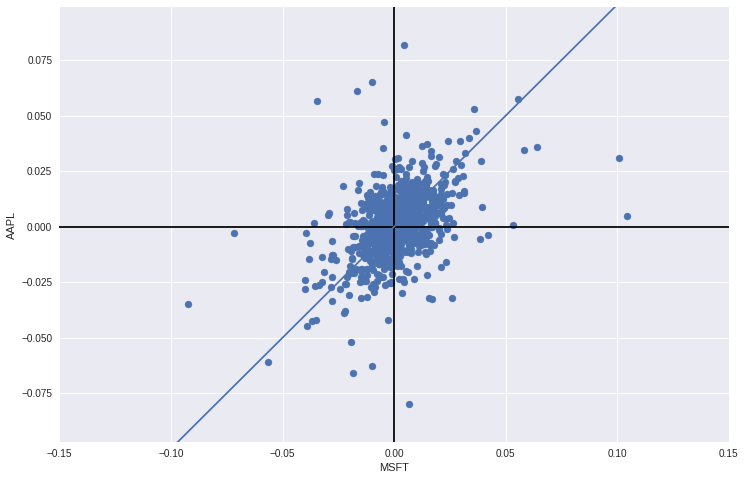

In [39]:
def render_scatter_plot(data, x_stock_name,y_stock_name, xlim=None, ylim=None):
  fig = plt.figure(figsize=(12,8))
  ax = fig.add_subplot(111)
  ax.scatter(data[x_stock_name], data[y_stock_name])
  if xlim is not None: ax.set_xlim(xlim)
  ax.autoscale(False)
  ax.vlines(0, -10, 10)
  ax.hlines(0, -10, 10)
  ax.plot((-10, 10), (-10, 10))
  ax.set_xlabel(x_stock_name)
  ax.set_ylabel(y_stock_name)

limits = [-0.15, 0.15]
render_scatter_plot(daily_pct_change, 'MSFT', 'AAPL', xlim=limits)

>>In this plot, excluding several outliers, this cluster appears to demonstrate a small
amount of correlation between the two stocks as the linear correlation would seem
to be closer to horizontal (slope = 0, that is, no correlation) than a perfect diagonal.
As we have seen, an actual correlation actually shows the correlation to be 0.236
(the slope of the regression line), which backs up our visual analysis.

>> This can be compared to the relationship between DAL and UAL , which shows very
high correlation:

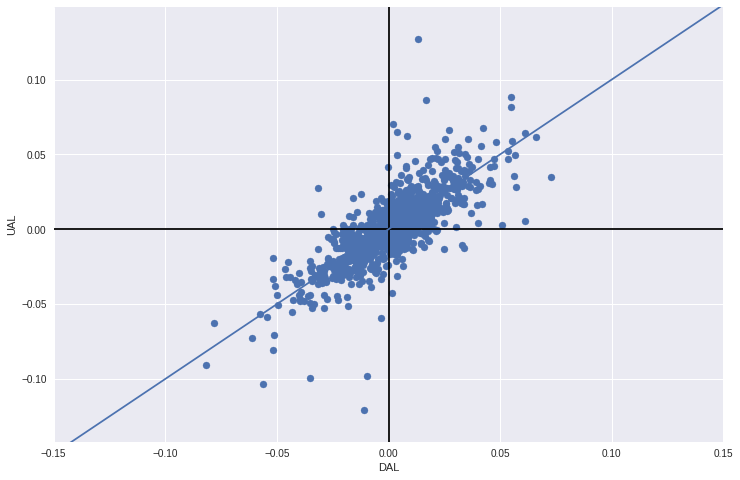

In [40]:
render_scatter_plot(daily_pct_change, 'DAL', 'UAL', xlim=limits)

This is supported with an actual correlation that is calculated to be 0.77


In [41]:
daily_pct_change.corr()

Ticker,AA,AAPL,DAL,GE,IBM,KO,MSFT,PEP,UAL
Ticker,,,,,,,,,
AA,1.000000,0.078357,0.087343,0.050158,0.049041,-0.023925,0.051425,-0.029745,0.071014
AAPL,0.078357,1.000000,0.290422,0.284952,0.294731,0.232301,0.441558,0.313507,0.216446
DAL,0.087343,0.290422,1.000000,0.327814,0.278232,0.219588,0.312059,0.259588,0.777633
GE,0.050158,0.284952,0.327814,1.000000,0.422779,0.303209,0.352121,0.355624,0.230457
IBM,0.049041,0.294731,0.278232,0.422779,1.000000,0.323588,0.409750,0.351537,0.209288
KO,-0.023925,0.232301,0.219588,0.303209,0.323588,1.000000,0.332762,0.687638,0.138398
MSFT,0.051425,0.441558,0.312059,0.352121,0.409750,0.332762,1.000000,0.378067,0.275852
PEP,-0.029745,0.313507,0.259588,0.355624,0.351537,0.687638,0.378067,1.000000,0.187365
UAL,0.071014,0.216446,0.777633,0.230457,0.209288,0.138398,0.275852,0.187365,1.000000


>>It is not required to draw every graph independently to compare all relationships.
The very useful scatter matrix graph provided by pandas plots the scatters for all
combinations of stocks that gives a very easy means of eyeballing all combinations.
The use of alpha=0.1 adds transparency to the points on the graph, which helps
with small graphs with many overlapping points, as shown here:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


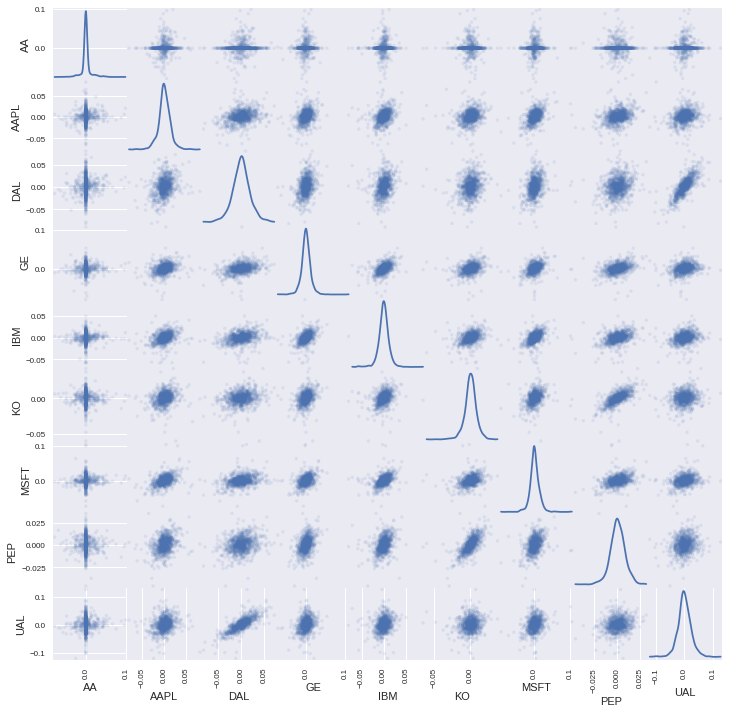

In [42]:
# all stocks against each other, with a KDE in the diagonal
_ = pd.scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12));

>>The diagonal is a kernel density estimation graph, which estimates the
distribution and, in simple terms, represents a continuous histogram of
the relationships.


>>**V.    Moving windows**: A number of functions are provided to compute moving (also known as rolling)
statistics, where the function computes the statistic on a window of data represented
by a particular period of time and then slides the window across the data by a
specified interval, continually calculating the statistic as long as the window falls first
within the dates of the time-series.

>>With the following functions, pandas provides direct support for rolling windows:

>>>Function :  Description

>>>rolling_mean : This is the mean of the values in the window

>>>rolling_std : This is the standard deviation of the values in the window

>>>rolling_var :This is the variance of values

>>>rolling_min : This is the minimum of the values in the window

>>>rolling_max : This is maximum of the values in the window

>>>rolling_cov : This is the covariance of values

>>>rolling_quantile : This is the moving window score at the percentile/sample quantile

>>>rolling_corr : This is the correlation of the values in the window

>>>rolling_median : This is the median of the values in the window

>>>rolling_sum : This is the sum of the values in the window

>>>rolling_apply : This is the application of a user function to the values in the window

>>>rolling_count : This is the number of non-NaN values in a window

>>>rolling_skew : This is the skewedness of the values in the window

>>>rolling_kurt : This is the kurtosis of the values in the window.


>>As a practical example, a rolling mean is commonly used to smooth out short-term
fluctuations and highlight longer-term trends in data and is used quite commonly in
financial time-series analysis.

>> To demonstrate this, we will calculate a rolling window on the adjusted close values
for MSFT for the year 2014. The following command extracts the raw values for 2012
and plots them to gives us an idea of the shape of the data:

In [43]:
msft = all_data.loc['MSFT'].loc['2014-01':'2014-12']

msftAC = msft['Adj. Close']
msftAC[:5]

Date
2014-01-02    33.532800
2014-01-03    33.307202
2014-01-06    32.603338
2014-01-07    32.856007
2014-01-08    32.269454
Name: Adj. Close, dtype: float64

>>The following command calculates the rolling mean with a window of 5 periods and
plots it against the raw data:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  


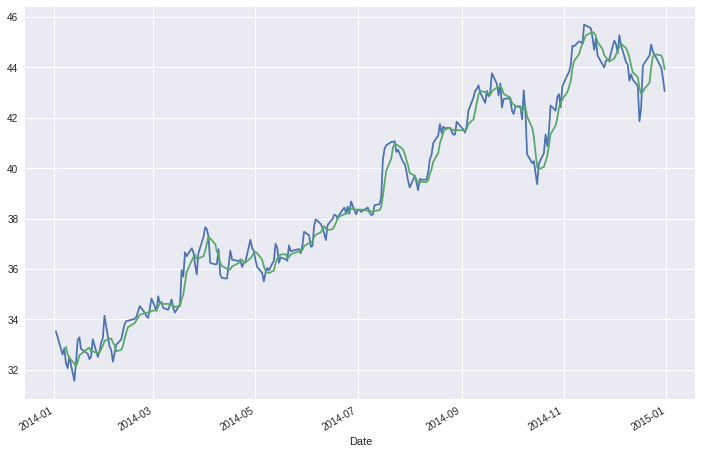

In [44]:
msftAC.plot(figsize=(12,8))
pd.rolling_mean(msftAC, 5).plot(figsize=(12,8));

>>From this, it can be seen how the pd.rolling_mean function provides a smoother
representation of the underlying data. A larger window smoothens out the variance
but at the cost of accuracy. We can see how this gets smoother as the window size
is increased. The following command plots the rolling mean of window size 5 , 10 ,
and 20 periods against the raw data:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  after removing the cwd from sys.path.


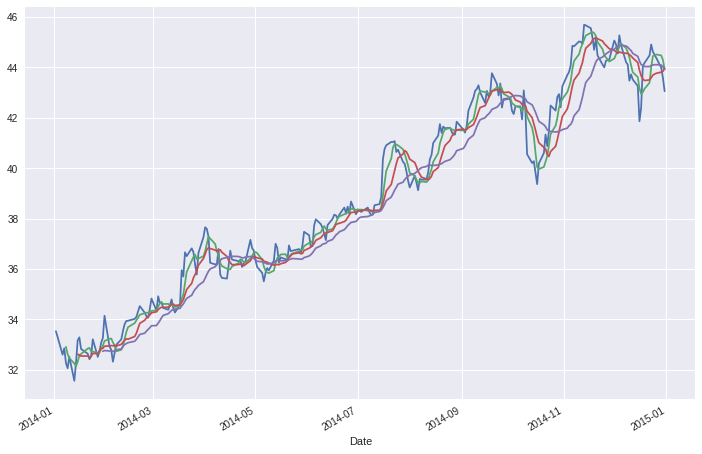

In [45]:
msftAC.plot(figsize=(12,8))
pd.rolling_mean(msftAC, 5).plot(figsize=(12,8))
pd.rolling_mean(msftAC, 10).plot(figsize=(12,8))
pd.rolling_mean(msftAC, 20).plot(figsize=(12,8));

>>Note that the larger the window, the more the data missing at the beginning of
the curve. A window of size n requires n data points before the measure can be
calculated, hence the gap in the beginning of the plot.

>>Any function can be applied via a rolling window using the pd.rolling_apply
function. The supplied function will be passed an array of values in the window
and should return a single value. Then pandas will combine these results into a
time-series.

>>To demonstrate this, the following command calculates the mean average deviation,
which gives a feel of how far on average all the values in the sample are from the
overall mean:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)
  


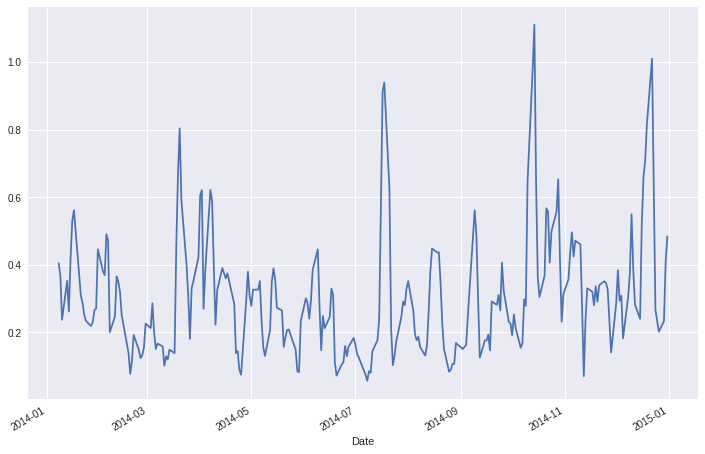

In [46]:
mean_abs_dev = lambda x: np.fabs(x - x.mean()).mean()
pd.rolling_apply(msftAC, 5, mean_abs_dev).plot(figsize=(12,8));

>>An expanding window mean can be calculated using a slight variant of the
pd.rolling_mean function that repeatedly calculates the mean by always starting
with the first value in the time-series, and for every iteration, increasing the window
size by one. An expanding window mean will be more stable (less responsive) than
a rolling window because greater the size of the window, the less the impact of the
next value:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.expanding_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


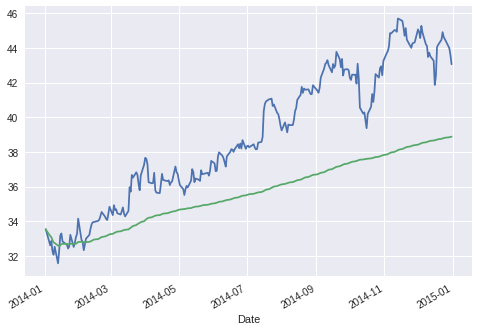

In [47]:
expanding_mean = lambda x: pd.rolling_mean(x, len(x), min_periods=1)
msftAC.plot()
pd.expanding_mean(msftAC).plot();

>>**VI.    Volatility calculation**:   The volatility of a stock is a measurement of the change in variance in the returns
of a stock over a specific period of time. It is common to compare the volatility of
a stock with another stock to get a feel for which may have less risk or to a market
index to examine the stock's volatility in the overall market. Generally, the higher the
volatility, the riskier the investment in that stock, which results in investing in one
over another.

>>Volatility is calculated by taking a rolling window standard deviation on the
percentage change in a stock. The size of the window affects the overall result. The
wider the window, the less representative the measurement will become. As the
window narrows, the result approaches the standard deviation. So, it is a bit of
an art to pick the proper window size based upon the data sampling frequency.
Fortunately, pandas makes this very easy to modify interactively.

>>As a demonstration, the following command calculates the volatility of all the stock
in our sample with a window of 75 days:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=75,center=False).std()
  


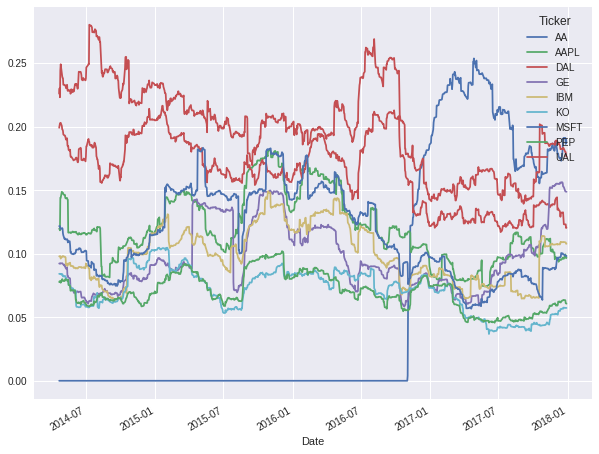

In [48]:
min_periods = 75
vol = pd.rolling_std(daily_pct_change, min_periods) * \
np.sqrt(min_periods)
vol.plot(figsize=(10, 8));

>>The lines higher on the chart represent overall higher volatility and hence represent
a riskier investment. PEP seems to have the lowest overall volatility, while it appears
that UAL has the highest

>>**VII.   Rolling correlation of returns**:    We previously examined the calculation of the overall correlation between two
stocks over a time period (3 years in our case). This can also be performed using
rolling windows to demonstrate how the correlation has changed over time:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=252).corr(other=<Series>)
  This is separate from the ipykernel package so we can avoid doing imports until


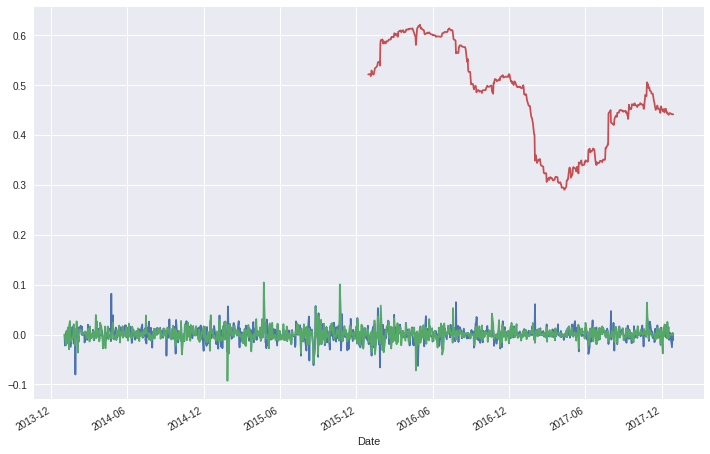

In [49]:
rolling_corr = pd.rolling_corr(daily_pct_change['AAPL'],
daily_pct_change['MSFT'],
window=252).dropna()
daily_pct_change['AAPL'].plot(figsize=(12,8))
daily_pct_change['MSFT'].plot(figsize=(12,8))
rolling_corr[251:].plot(figsize=(12,8))

>>**VIII.    Comparing stocks to the S&P 500**:   The analyses until this point have been performed only between stocks. It is often
useful to perform some of these against a market index such as the S&P 500. This
will give a sense of how those stocks compare to movements in the overall market.

>>At the beginning of the chapter, we loaded the S&P 500 data for the same time period
as the other stocks. To perform comparisons, we can perform the same calculations
to derive the daily percentage change and cumulative returns on the index:

In [50]:
sp_500_dpc = sp_500['Adj Close'].pct_change().fillna(0)
sp_500_dpc[:5]

Date
2014-01-02    0.000000
2014-01-03   -0.000333
2014-01-06   -0.002512
2014-01-07    0.006082
2014-01-08   -0.000212
Name: Adj Close, dtype: float64

>>We can concatenate the index calculations in the results of the calculations of the
stocks. This will let us easily compare the overall set of stocks and index calculations:

In [51]:
dpc_all = pd.concat([sp_500_dpc, daily_pct_change], axis=1)
dpc_all.rename(columns={'Adj Close': 'SP500'}, inplace=True)
dpc_all[:5]

,SP500,AA,AAPL,DAL,GE,IBM,KO,MSFT,PEP,UAL
Date,,,,,,,,,,
2014-01-02,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-03,-0.000333,0.0,-0.021966,0.055235,-0.000727,0.005983,-0.004919,-0.006728,0.001705,0.058839
2014-01-06,-0.002512,0.0,0.005453,0.002053,-0.008006,-0.003429,-0.004696,-0.021132,0.000486,-0.014768
2014-01-07,0.006082,0.0,-0.007156,-0.017412,0.001101,0.019946,0.002980,0.007750,0.014584,-0.017022
2014-01-08,-0.000212,0.0,0.006338,0.035441,-0.002931,-0.009172,-0.011141,-0.017852,-0.002875,0.060222


>>Now, we calculate the cumulative daily returns with the following command:

In [52]:
cdr_all = (1 + dpc_all).cumprod()
cdr_all[:5]

,SP500,AA,AAPL,DAL,GE,IBM,KO,MSFT,PEP,UAL
Date,,,,,,,,,,
2014-01-02,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2014-01-03,0.999667,1.0,0.978034,1.055235,0.999273,1.005983,0.995081,0.993272,1.001705,1.058839
2014-01-06,0.997156,1.0,0.983367,1.057401,0.991273,1.002533,0.990408,0.972282,1.002192,1.043202
2014-01-07,1.003221,1.0,0.976330,1.038989,0.992364,1.022530,0.993360,0.979817,1.016809,1.025444
2014-01-08,1.003008,1.0,0.982518,1.075812,0.989455,1.013152,0.982292,0.962325,1.013886,1.087199


In [53]:
dpc_corrs = dpc_all.corr()
dpc_corrs.loc[:,'SP500']

SP500    1.000000
AA       0.111651
AAPL     0.563346
DAL      0.543778
GE       0.631079
IBM      0.584660
KO       0.491881
MSFT     0.658491
PEP      0.571030
UAL      0.435687
Name: SP500, dtype: float64

>>GE, MSFT shows that it moved in the most similar way to the S&P 500. A plot of the returns shows this, as GE , MSFT indeed
follows right along the S&P 500, which was quite a good investment relative to the
S&P 500

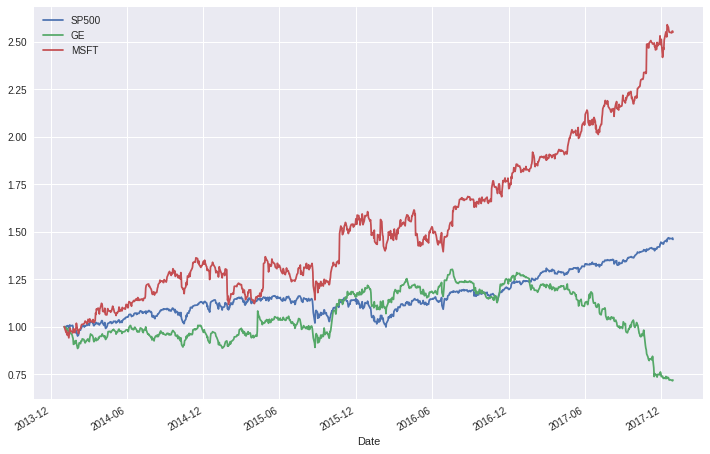

In [54]:
_ = cdr_all[['SP500', 'GE', 'MSFT']].plot(figsize=(12,8));

>>We can examine these conclusions with scatter plots of both against the S&P 500, as
shown here:

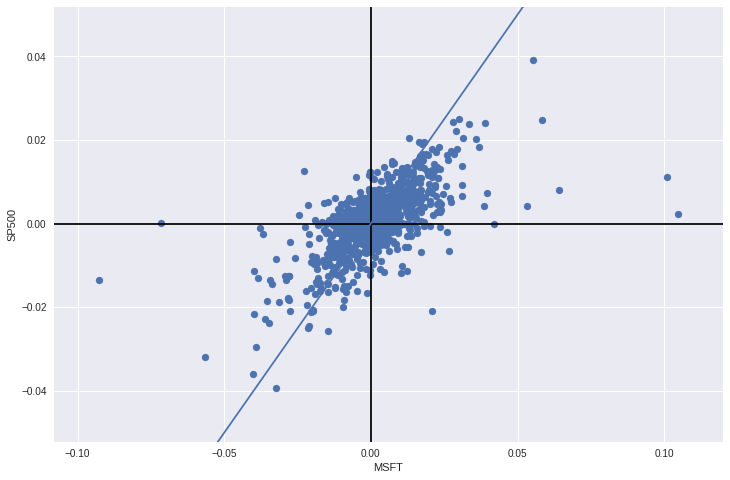

In [55]:
render_scatter_plot(dpc_all, 'MSFT', 'SP500')
plt.savefig('5104_05_23.png', bbox_inches='tight', dpi=300)

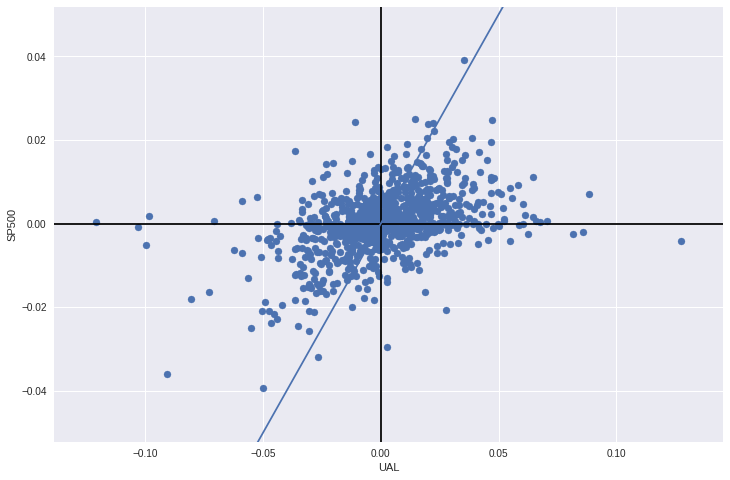

In [56]:
render_scatter_plot(dpc_all, 'UAL', 'SP500')

>>This shows that GE is fairly tightly correlated to the S&P 500. UAL has a much more
distributed cluster of points around the origin, which supports that it has a lot less
correlation.